# classification-21

## What's new:

1- https://chatgpt.com/c/6935b759-989c-832f-ae2d-1ac4e399fa7d

section: 3


## next step:

1-


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, TimeDistributed, Lambda, RepeatVector, Dropout, \
    BatchNormalization
from tensorflow.keras import Input, layers, models, callbacks, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, find_peaks, peak_prominences
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight

import datetime
import joblib
import json
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [4]:
df.shape

(179856, 10)

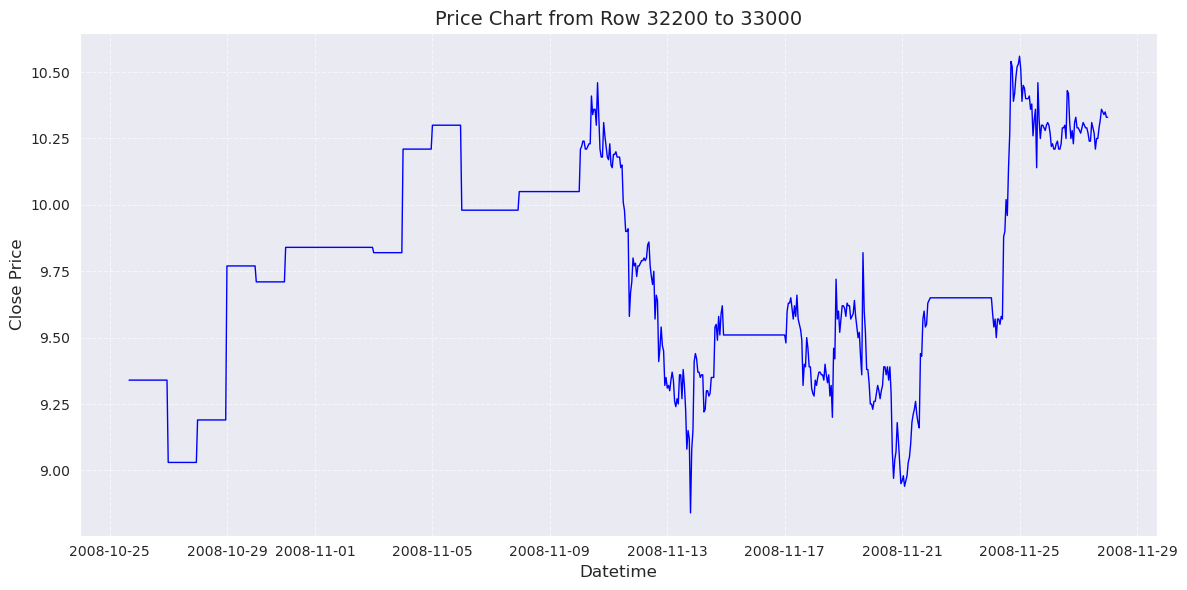

In [5]:
# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [7]:
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,  # 0.15% minimum leg size
        min_dev_sigma=2.0,  # >= 2x local abs-return EMA
        vol_window=100,  # EMA window for local volatility
        verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:  # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n - 1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [8]:
# baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

labels -> 0:144229  1:1063  2:1064  (extrema kept: 2125)
Label
0    144229
2      1064
1      1063
Name: count, dtype: int64


In [9]:
# Display label distribution in df_model
label_counts = df_model['Label'].value_counts().sort_index()
label_percentages = (df_model['Label'].value_counts(normalize=True) * 100).sort_index()

print("Label Distribution in df_model:")
print("-" * 40)
for label in sorted(df_model['Label'].unique()):
    count = label_counts[label]
    percentage = label_percentages[label]
    print(f"Class {label}: {count:,} rows ({percentage:.2f}%)")
print("-" * 40)
print(f"Total rows: {len(df_model):,}")


Label Distribution in df_model:
----------------------------------------
Class 0: 144,229 rows (98.55%)
Class 1: 1,063 rows (0.73%)
Class 2: 1,064 rows (0.73%)
----------------------------------------
Total rows: 146,356


In [10]:
def plot_labeled_candles(df_model, n=1000):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df_model.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



In [ ]:
plot_labeled_candles(df_model)

# plot section

In [ ]:
# --------------------------
# === Visualization Block ===
# --------------------------

historical_df = input_df.tail(4).copy()

In [ ]:
historical_df

In [ ]:
# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = given_idx + 1
actual_future_end = given_idx + FORECAST_HORIZON + 1
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()



In [ ]:
actual_future_df

In [ ]:
# --- 4. Add text labels for clarity ---
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



In [ ]:
# --- 6. Import your plotting utility ---

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [ ]:
# 11- Save Model with Comprehensive Report
from datetime import datetime
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# 1- Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 2- Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs('saved_models', exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# 3- Save model
print(f"\n[SAVING MODEL]")
model.save(model_path)
print(f"Model saved to: {model_path}")

In [ ]:

# 4- Save scaler (IMPORTANT - needed for predictions!)
import joblib

scaler_path = os.path.join('saved_models', f'scaler_{timestamp}.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 5- Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)
print(f"Training history saved")

# 6- Save full history as JSON so it can be reloaded later
history_json_path = os.path.join(log_dir, 'history.json')
with open(history_json_path, 'w') as f:
    json.dump(history.history, f)

print(f"Full history object saved to: {history_json_path}")

In [ ]:
# 7 — Save Training Loss Plot
import matplotlib.pyplot as plt

loss_plot_path = os.path.join(log_dir, "training_loss.png")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(loss_plot_path)
plt.close()

print(f"Loss plot saved to: {loss_plot_path}")

In [ ]:
# 8 — Save Accuracy Plot
acc_plot_path = os.path.join(log_dir, "training_accuracy.png")

plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(acc_plot_path)
plt.close()

print(f"Accuracy plot saved to: {acc_plot_path}")

In [ ]:
# 9 — Evaluate on validation set
print("\n[EVALUATING ON VALIDATION SET]")
val_loss, val_acc = model.evaluate(
    X_val_tf,
    y_val_tf,
    sample_weight=sample_weight_seq_val,
    verbose=1
)
print(f"Validation Loss: {val_loss:.6f}")
print(f"Validation Accuracy: {val_acc:.6f}")

In [ ]:
# 10 — Generate detailed predictions
print("\n[GENERATING VALIDATION PREDICTIONS]")

# Predictions shape: (samples, horizon, 3)
val_pred_prob = model.predict(X_val_tf, verbose=1)

# Convert to integer labels
val_pred = np.argmax(val_pred_prob, axis=-1)   # shape: (samples, horizon)
val_true = y_val_tf                            # shape: (samples, horizon)


# For reporting: flatten all horizon steps
val_pred_flat = val_pred.flatten()
val_true_flat = val_true.flatten()

In [ ]:
# 11 — Confusion Matrix Plot
cm = confusion_matrix(val_true_flat, val_pred_flat)

cm_plot_path = os.path.join(log_dir, "confusion_matrix.png")

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['0','1','2'],
            yticklabels=['0','1','2'])
plt.title("Confusion Matrix (Flattened Horizon)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(cm_plot_path)
plt.close()

print(f"Confusion matrix saved to: {cm_plot_path}")

In [ ]:

# 12 — Per-class performance plot
report_dict = classification_report(val_true_flat, val_pred_flat, output_dict=True)

perf_plot_path = os.path.join(log_dir, "per_class_performance.png")

classes = ['0','1','2']
precisions = [report_dict[c]['precision'] for c in classes]
recalls    = [report_dict[c]['recall'] for c in classes]
f1s        = [report_dict[c]['f1-score'] for c in classes]

plt.figure(figsize=(10, 6))
x = np.arange(len(classes))

plt.plot(x, precisions, marker='o', label="Precision")
plt.plot(x, recalls, marker='o', label="Recall")
plt.plot(x, f1s, marker='o', label="F1-Score")

plt.xticks(x, classes)
plt.ylim(0, 1)
plt.title("Per-Class Performance (Flattened Horizon)")
plt.xlabel("Class")
plt.ylabel("Score")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(perf_plot_path)
plt.close()

print(f"Per-class performance plot saved to: {perf_plot_path}")


In [ ]:

# 13 — Create comprehensive text report
report_text = []
report_text.append("========== MODEL PERFORMANCE REPORT ==========\n")
report_text.append(f"Timestamp: {timestamp}\n")
report_text.append(f"Model file: {model_filename}\n")
report_text.append("\n--- Validation Metrics ---\n")
report_text.append(f"Validation Loss: {val_loss:.6f}\n")
report_text.append(f"Validation Accuracy: {val_acc:.6f}\n")

report_text.append("\n--- Classification Report (Flattened Horizon) ---\n")
report_text.append(classification_report(val_true_flat, val_pred_flat))

report_text.append("\n--- Class Distribution in Validation (Flattened) ---\n")
unique, counts = np.unique(val_true_flat, return_counts=True)
dist = dict(zip(unique, counts))
report_text.append(str(dist) + "\n")

report_text.append("\n--- Files Saved ---\n")
report_text.append(f"Training loss plot: {loss_plot_path}\n")
report_text.append(f"Training accuracy plot: {acc_plot_path}\n")
report_text.append(f"Confusion matrix: {cm_plot_path}\n")
report_text.append(f"Per-class performance plot: {perf_plot_path}\n")


# 14 — Save comprehensive report
report_path = os.path.join(log_dir, "comprehensive_report.txt")

with open(report_path, "w") as f:
    f.write("\n".join(report_text))

print(f"Comprehensive report saved to: {report_path}")


# 15 — Save model summary separately
summary_path = os.path.join(log_dir, "model_summary.txt")

with open(summary_path, "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

print(f"Model summary saved to: {summary_path}")


In [ ]:
# 1- Load model
model_path = 'saved_models/model_20251204_120838.keras'
model = keras.models.load_model(model_path)

# 2- Load scaler
scaler_path = 'saved_models/scaler_20251204_120838.pkl'
scaler = joblib.load(scaler_path)

# 3- Load history JSON
log_dir = 'saved_models/model_20251204_120838_logs'
history_json_path = os.path.join(log_dir, 'history.json')

with open(history_json_path, 'r') as f:
    history_dict = json.load(f)


# create history-like object
class ReloadedHistory:
    def __init__(self, hdict):
        self.history = hdict


history = ReloadedHistory(history_dict)

# Now you can access history just like before
print(history.history.keys())
print(history.history['loss'][:5])
